This file contains script for initially working with GeoTIFF images: visualizing, removing unnedded bands, and resizing to 512x512

In [9]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show

In [48]:
file_path = '../../presentation_data/2yr_anl_full/'
file1 = 'planet_medres_normalized_analytic_2017-06_2017-11_mosaic_674-931.tif'
testfile = file_path + file1

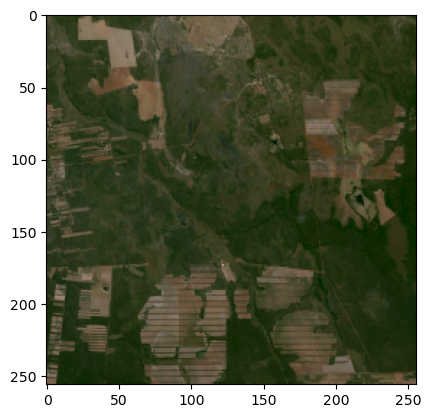

In [49]:
#Let's look at a visual example as reference
from PIL import Image
img = np.asarray(Image.open('../../presentation_data/allyr_anl/planet_medres_normalized_analytic_2017-06_2017-11_mosaic_674-931.png'))
plt.imshow(img)

In [50]:
with rasterio.open(testfile) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 4096, 'height': 4096, 'count': 5, 'crs': CRS.from_epsg(3857), 'transform': Affine(4.77731426716, 0.0, -6848757.733394317,
       0.0, -4.77731426716, -1800244.8899161778), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


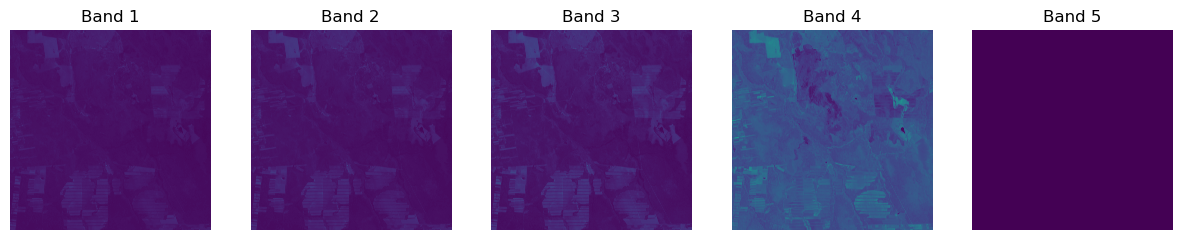

In [51]:
with rasterio.open(testfile) as src:
    fig, axarr = plt.subplots(1, src.count, figsize=(15, 5))
    
    for i in range(src.count): #note all PlanetScope 4-band images have band order BGRN
        band = src.read(i+1)
        axarr[i].imshow(band)
        axarr[i].set_title(f'Band {i+1}')
        axarr[i].axis('off')

    plt.show()

In [52]:


# Open the GeoTIFF file
with rasterio.open(testfile) as src: #note all PlanetScope 4-band images have band order BGRN
    # Read the individual bands
    red = src.read(3)
    green = src.read(2)
    blue = src.read(1)
    alpha = src.read(5)  # Alpha band
    nir = src.read(4)

    # Create an RGB image (without Alpha)
    rgb = np.dstack((red, green, blue))




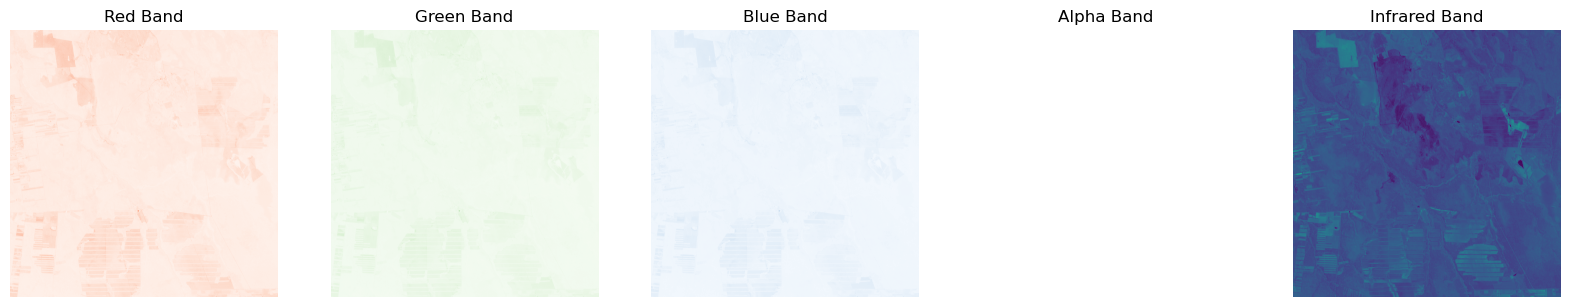

In [53]:
# Display each band separately
fig, axarr = plt.subplots(1, 5, figsize=(20, 5))
axarr[0].imshow(red, cmap='Reds')
axarr[0].set_title('Red Band')
axarr[0].axis('off')

axarr[1].imshow(green, cmap='Greens')
axarr[1].set_title('Green Band')
axarr[1].axis('off')

axarr[2].imshow(blue, cmap='Blues')
axarr[2].set_title('Blue Band')
axarr[2].axis('off')

axarr[3].imshow(alpha, cmap='Greys')
axarr[3].set_title('Alpha Band')
axarr[3].axis('off')

axarr[4].imshow(nir)
axarr[4].set_title('Infrared Band')
axarr[4].axis('off')


plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


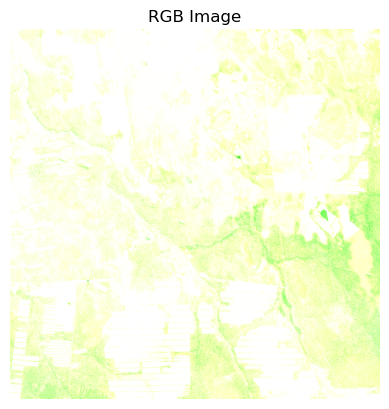

In [54]:
# Display the RGB image
plt.imshow(rgb)
plt.title('RGB Image')
plt.axis('off')
plt.show()

In [55]:
#calculate NDVI
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)

# check range NDVI values, excluding NaN
np.nanmin(ndvi), np.nanmax(ndvi)

(-0.02468085106382979, 1.0)

In [56]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open('../../presentation_data/output/ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

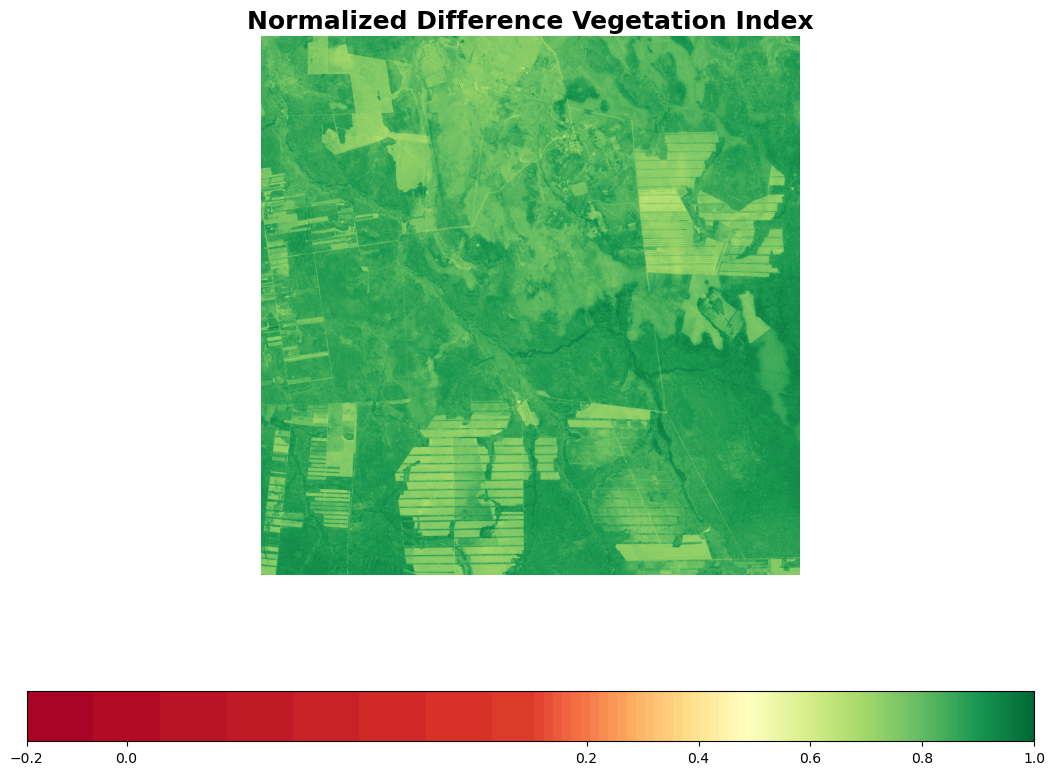

In [57]:
import matplotlib.colors as colors

"""
The NDVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Normalized Difference Vegetation Index', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

fig.savefig("../../presentation_data/output/ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

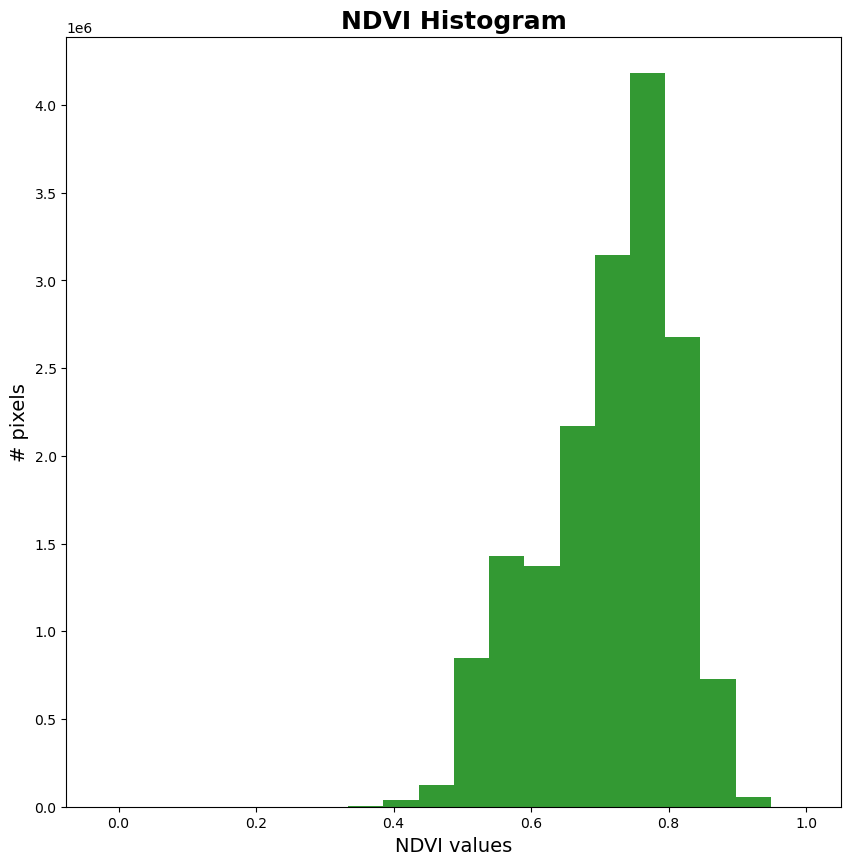

In [58]:
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = ndvi[~np.isnan(ndvi)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)

fig2.savefig("../../presentation_data/output/ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

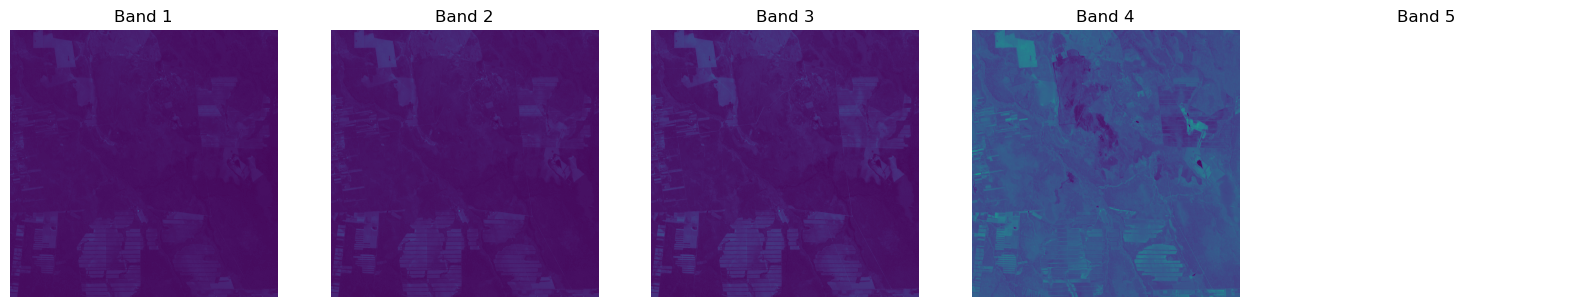

In [60]:

def normalize(array):
    """Normalize the array to 0-1 scale."""
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)



with rasterio.open(testfile) as src:
    fig, axarr = plt.subplots(1, src.count, figsize=(20, 5))
    
    for i in range(src.count):
        band = src.read(i+1)
        normalized_band = normalize(band)
        
        axarr[i].imshow(normalized_band)
        axarr[i].set_title(f'Band {i+1}')
        axarr[i].axis('off')

    plt.show()


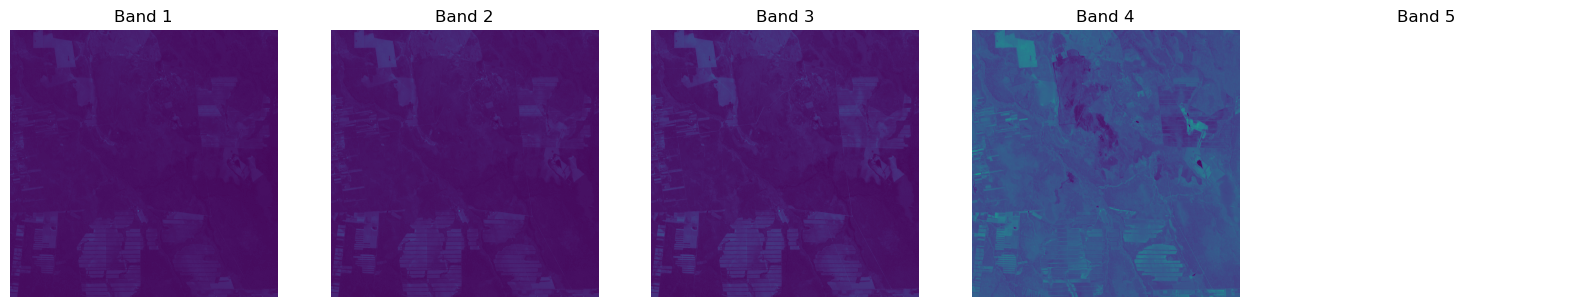

In [61]:
def normalize_to_8bit(array):
    """Normalize the array to 0-255 scale."""
    array_min, array_max = array.min(), array.max()
    normalized = (array - array_min) / (array_max - array_min)
    return (normalized * 255).astype(np.uint8)

with rasterio.open(testfile) as src:
    fig, axarr = plt.subplots(1, src.count, figsize=(20, 5))
    
    for i in range(src.count):
        band = src.read(i+1)
        normalized_band = normalize(band)
        
        axarr[i].imshow(normalized_band)
        axarr[i].set_title(f'Band {i+1}')
        axarr[i].axis('off')

    plt.show()


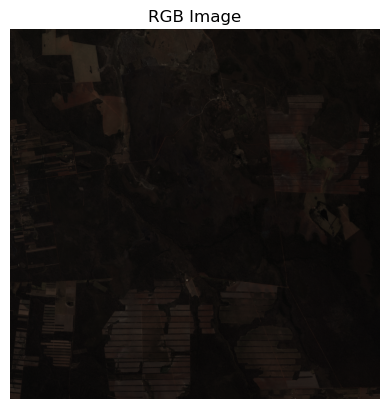

In [62]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def normalize(array):
    """Normalize the array to 0-1 scale."""
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)



with rasterio.open(testfile) as src:
    # Assuming that the bands are ordered as Blue, Green, Red
    blue = src.read(1)
    green = src.read(2)
    red = src.read(3)

    # Normalize the bands
    blue_normalized = normalize(blue)
    green_normalized = normalize(green)
    red_normalized = normalize(red)

    # Stack the bands in RGB order
    rgb = np.dstack((red_normalized, green_normalized, blue_normalized))

# Display the RGB image
plt.imshow(rgb)
plt.title('RGB Image')
plt.axis('off')
plt.show()
